### Download the demo movie

In [1]:
%%bash

mkdir ../../data

GDRIVE_DEMO_MOVIE_FILEID=1v8E61-mKwyGNVPQFrLabsLsjA-l6D21E
FILE_NAME=../../data/demoMovie.npy

function gdrive_download () {
  CONFIRM=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate "https://docs.google.com/uc?export=download&id=$1" -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')
  wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$CONFIRM&id=$1" -O $2
  rm -rf /tmp/cookies.txt
}

gdrive_download ${GDRIVE_DEMO_MOVIE_FILEID} ${FILE_NAME}

main: line 8: wget: command not found
main: line 9: wget: command not found


In [2]:
# General Dependencies
import os
import numpy as np
import platform
print(platform.python_version())
import inspect
from tifffile import imread
from tifffile import imwrite

print(np.__version__)
# Preprocessing Dependencies
from trefide.utils import psd_noise_estimate

# PMD Model Dependencies
from trefide.pmd import batch_decompose,\
                        batch_recompose,\
                        overlapping_batch_decompose,\
                        overlapping_batch_recompose,\
                        determine_thresholds
from trefide.reformat import overlapping_component_reformat

# Plotting & Video Rendering Dependencies
import matplotlib.pyplot as plt
from trefide.plot import pixelwise_ranks
from trefide.extras.util_plot import comparison_plot
from trefide.video import play_cv2

# Set Demo Dataset Location
ext = os.path.join("../Data//Optosynth/", "raw/")
filename = os.path.join(ext, "optosynth__1__20__5.tif")

%load_ext autoreload
%autoreload 2

3.9.21
1.19.5


In [5]:

mov = np.ascontiguousarray(np.array(imread(filename), dtype='d')[100:200])
print(mov.shape)
mov = np.ascontiguousarray(np.transpose(mov, (1, 2, 0)))
print(mov.shape)

(100, 180, 512)
(180, 512, 100)


In [4]:
mov = np.ascontiguousarray(mov[2:114, 9:489])
print(mov.shape)
print(mov.flags)

(98, 171, 512)
  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False



### Load Preprocessed Data and set parameters

In [11]:
fov_height, fov_width, num_frames = mov.shape
print(mov.shape)
# Generous maximum of rank 50 blocks (safeguard to terminate early if this is hit)
max_components = 50

# Enable Decimation 
max_iters_main = 10
max_iters_init = 40
d_sub = 2
t_sub = 2

# Defaults
consec_failures = 3
tol = 5e-3

# Set Blocksize Parameters
block_height = 36
block_width = 32
overlapping = True
enable_temporal_denoiser = True
enable_spatial_denoiser = True

(180, 512, 7000)


### Simulate Critical Region Using Noise, determine spatial & temporal threshold

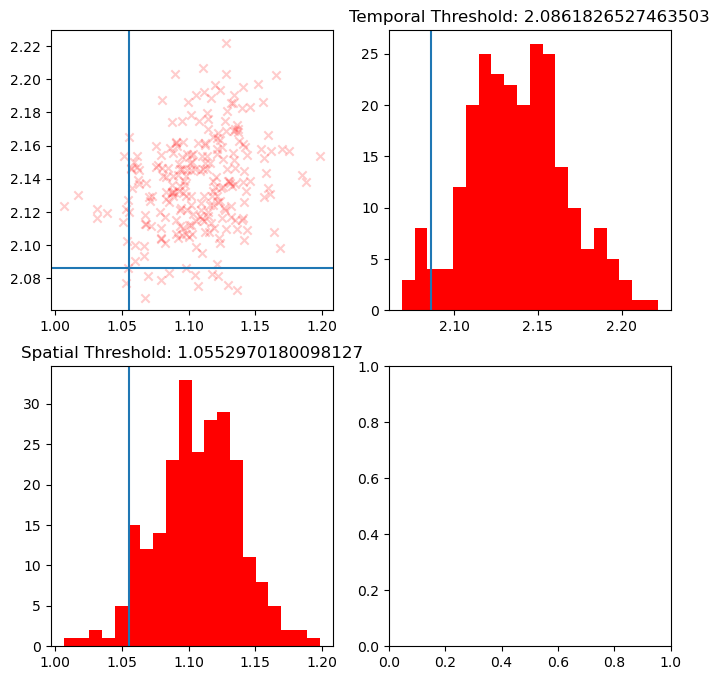

CPU times: user 6min 20s, sys: 4.72 s, total: 6min 24s
Wall time: 54.8 s


In [12]:
%%time
spatial_thresh, temporal_thresh = determine_thresholds((fov_height, fov_width, num_frames),
                                                       (block_height, block_width),
                                                       consec_failures, max_iters_main, 
                                                       max_iters_init, tol, 
                                                       d_sub, t_sub, 5, True,
                                                       enable_temporal_denoiser,
                                                       enable_spatial_denoiser)

### Decompose Each Block Into Spatial & Temporal Components

In [13]:
%%time
if not overlapping:    # Blockwise Parallel, Single Tiling
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices = batch_decompose(fov_height, fov_width, num_frames,
                                    mov, block_height, block_width,
                                    spatial_thresh, temporal_thresh,
                                    max_components, consec_failures,
                                    max_iters_main, max_iters_init, tol,
                                    d_sub, t_sub,
                                    enable_temporal_denoiser, enable_spatial_denoiser)
    
else:    # Blockwise Parallel, 4x Overlapping Tiling

    arr = (fov_height, fov_width, num_frames,
                                                mov, block_height, block_width,
                                                spatial_thresh, temporal_thresh,
                                                max_components, consec_failures,
                                                max_iters_main, max_iters_init, tol,
                                                d_sub, t_sub,
                                                enable_temporal_denoiser, enable_spatial_denoiser)
    
    spatial_components,\
    temporal_components,\
    block_ranks,\
    block_indices,\
    block_weights = overlapping_batch_decompose(fov_height, fov_width, num_frames,
                                                mov, block_height, block_width,
                                                spatial_thresh, temporal_thresh,
                                                max_components, consec_failures,
                                                max_iters_main, max_iters_init, tol,
                                                d_sub, t_sub,
                                                enable_temporal_denoiser, enable_spatial_denoiser)

CPU times: user 1h 4min 52s, sys: 16.1 s, total: 1h 5min 9s
Wall time: 6min 33s


### Reconstruct Denoised Video

In [14]:
%%time
if not overlapping:  # Single Tiling (No need for reqweighting)
    mov_denoised = np.asarray(batch_recompose(spatial_components,
                                              temporal_components,
                                              block_ranks,
                                              block_indices))
else:   # Overlapping Tilings With Reweighting
    mov_denoised = np.asarray(overlapping_batch_recompose(fov_height, fov_width, num_frames,
                                                          block_height, block_width,
                                                          spatial_components,
                                                          temporal_components,
                                                          block_ranks,
                                                          block_indices,
                                                          block_weights))
    

CPU times: user 1min 5s, sys: 20.8 s, total: 1min 26s
Wall time: 1min 26s


In [ ]:
mov_compressed = np.array(mov_denoised, dtype='float32')

# shape needs to be tyx
mov_compressed = mov_compressed.transpose(2, 0, 1)

print(mov_compressed.shape)


imwrite('../Data/Optosynth/pmd/optosynth__1__20__5_2.tif', mov_compressed)

### Produce Diagnostics, Single Tiling Pixel-Wise Ranks

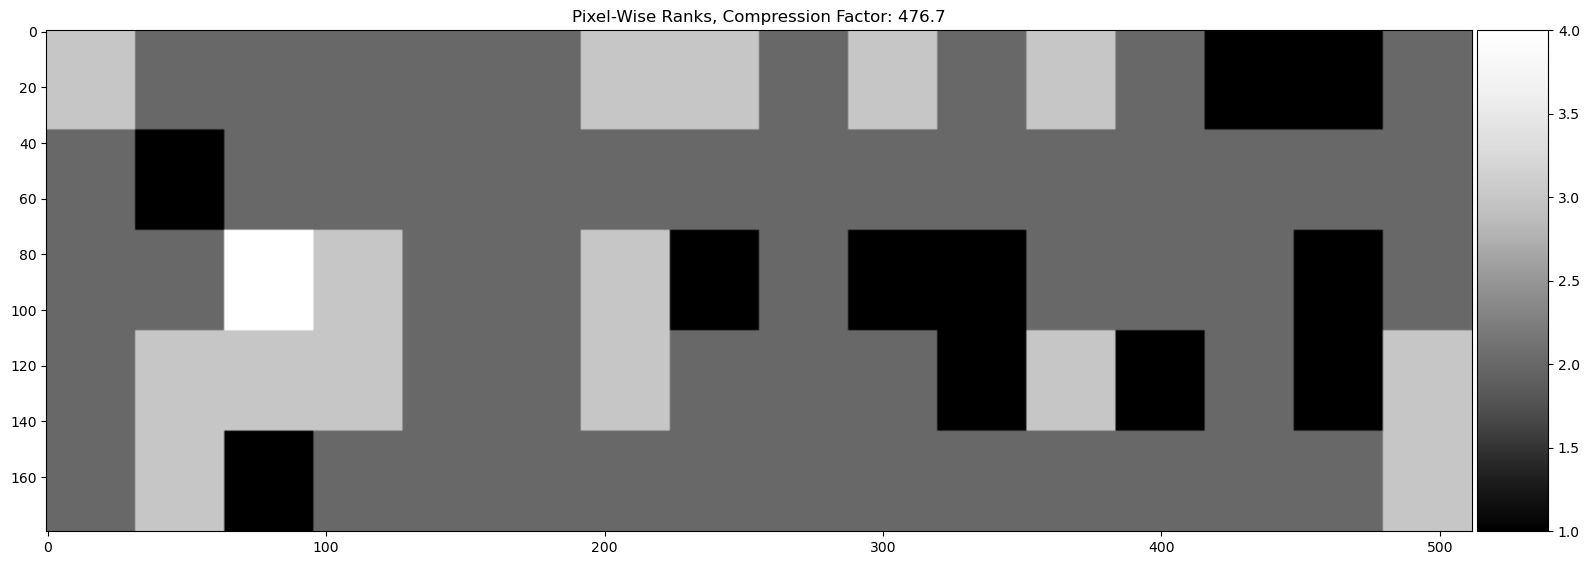

In [15]:
if overlapping:
    pixelwise_ranks(block_ranks['no_skew']['full'], fov_height, fov_width, num_frames, block_height, block_width)
else:
    pixelwise_ranks(block_ranks, fov_height, fov_width, num_frames, block_height, block_width)

### Correlation Images

Local correlation:  range [-2.2e-02 1.1e-01]
Local correlation:  range [-3.6e-01 1.0e+00]
Local correlation:  range [-1.0e-01 1.8e-02]


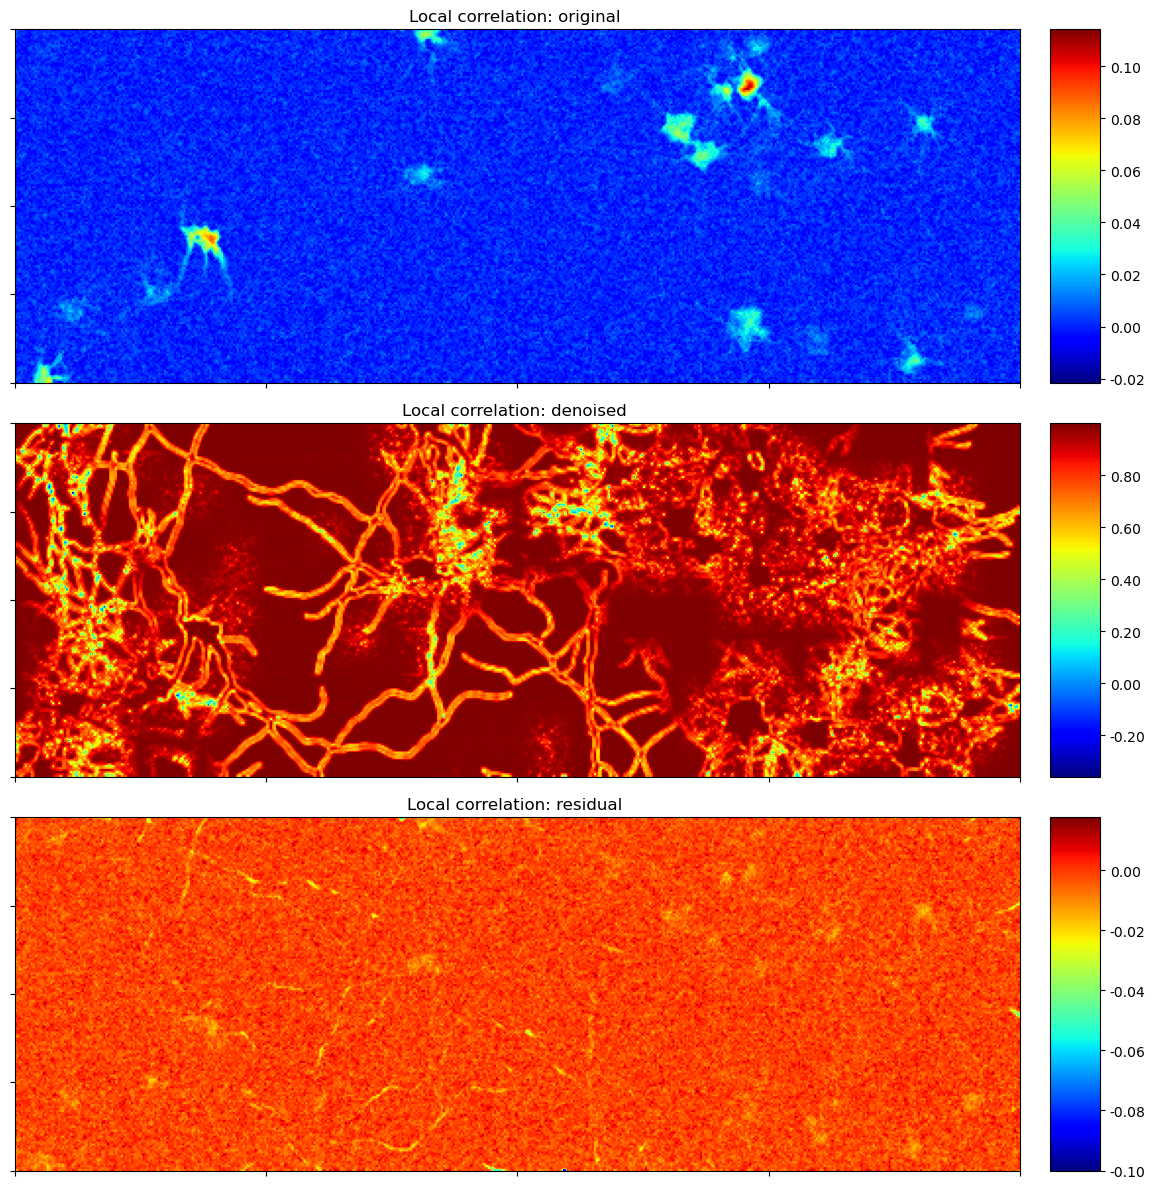

In [16]:
comparison_plot([mov, mov_denoised + np.random.randn(np.prod(mov.shape)).
                 reshape(mov.shape)*.01],
                plot_orientation="horizontal")

### Save Results

In [20]:
U, V = overlapping_component_reformat(fov_height, fov_width, num_frames,
                                      block_height, block_width,
                                      spatial_components,
                                      temporal_components,
                                      block_ranks,
                                      block_indices,
                                      block_weights)

In [ ]:
np.savez(os.path.join(ext, "demo_results.npz"), U, V)